In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skimage.morphology import binary_opening, disk
from keras.models import load_model
from matplotlib.cm import get_cmap
from skimage.io import imread

from utils import masks_as_color, multi_rle_encode
from configs import TRAIN_DATA_FOLDER, TEST_DATA_FOLDER

# Get validation set for prediction testing

In [6]:
masks = pd.read_csv(os.path.join('data', 'train_ship_segmentations_v2.csv'))
valid_df = pd.read_csv('data/valid.csv')

In [7]:
# Set the root to train/test dataframes
train_image_dir = os.path.join('data', TRAIN_DATA_FOLDER)
test_image_dir = os.path.join('data', TEST_DATA_FOLDER)

# Open U-net model
fullres_model = load_model('fullres_model.h5')

# Viewing results
Results will be save at the main folder to validation.png

1/1 [==============================] - 0s 306ms/step


C:\Users\YARIK\AppData\Local\Temp\ipykernel_11708\306876187.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))


1/1 [==============================] - 0s 98ms/step


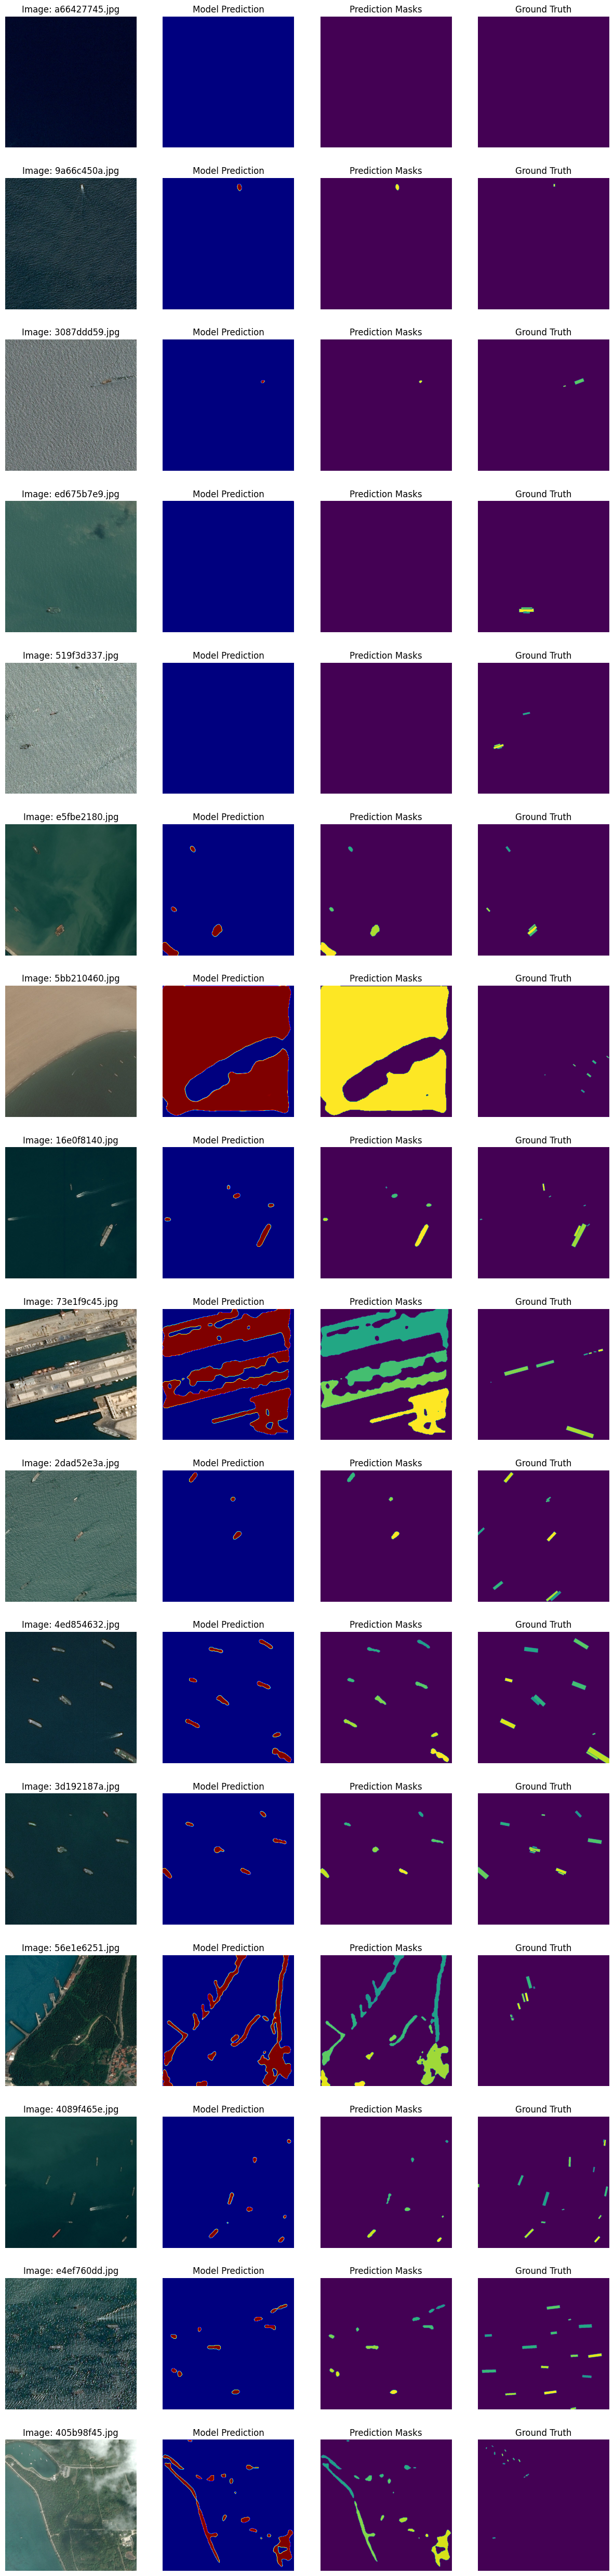

In [8]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')

fig.savefig('validation.png')